#### SGD Classifier

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict

from src.paths import TRANSFORMED_DATA_DIR
from src.pipeline import get_pipeline
from src.split_and_tfidf import split_and_vect
from src.stemming_and_lemming import stem_reviews

In [3]:
df = pd.read_parquet(TRANSFORMED_DATA_DIR /'cleaned_sentiments.parquet')

In [4]:
df_copy = df.copy()

<Axes: xlabel='recommended'>

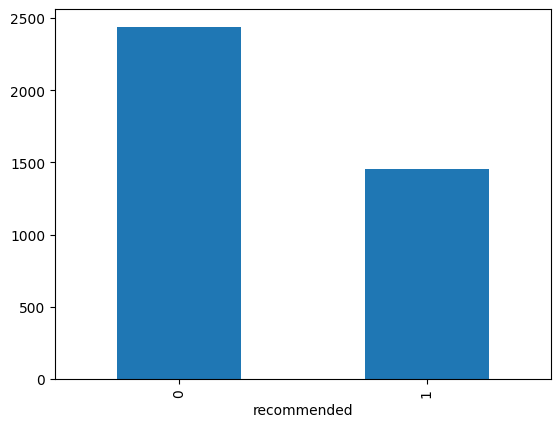

In [5]:
df['recommended'].value_counts().plot(kind='bar')

In [6]:
# split the data and fit a tfidf vectorizer to ita
X_train_vec, X_test_vec, y_train, y_test, tfidf_vec = split_and_vect(df_copy, 'cleaned', 'recommended')

In [7]:
# sgd classifier
sgd = SGDClassifier()

# fit to tfidf vectorizer
sgd.fit(X_train_vec, y_train)

# make predictions
y_pred = cross_val_predict(sgd, X_train_vec, y_train, cv = 5)

In [8]:
# metrics 
report = classification_report(y_train, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1952
           1       0.90      0.80      0.85      1163

    accuracy                           0.89      3115
   macro avg       0.89      0.87      0.88      3115
weighted avg       0.89      0.89      0.89      3115



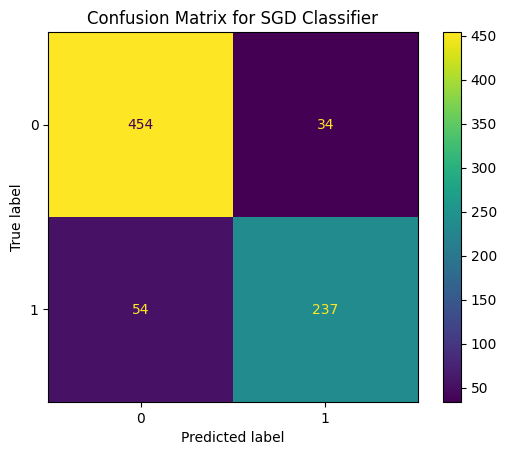

In [9]:
ConfusionMatrixDisplay.from_estimator(sgd, X_test_vec, y_test)
plt.title('Confusion Matrix for SGD Classifier')
plt.show()

In [10]:
# stemming
df_stem = df.copy()

# perform stemming on the data
df_stem['stemmed'] = stem_reviews(df_stem['cleaned'])

In [11]:
df_stem.tail()

,recommended,cleaned,stemmed
3887,0,Business LHR to BKK 747 400 First try back wit...,busi lhr to bkk 747 400 first tri back with ba...
3890,1,LHR to HAM Purser addresses all club passenger...,lhr to ham purser address all club passeng by ...
3891,0,My son who had worked for British Airways urge...,my son who had work for british airway urg me ...
3892,0,London City New York JFK via Shannon on A318 b...,london citi new york jfk via shannon on a318 b...
3893,0,SIN LHR BA12 B747 436 First Class Old aircraft...,sin lhr ba12 b747 436 first class old aircraft...


In [12]:
# split and vectorize
X_train_stem, X_test_stem, y_train, y_test, tfidf_stem_vec = split_and_vect(df_stem, 'stemmed', 'recommended')

# fit stemmed to sgd
# instantiate
sgd_stem = SGDClassifier()

# fit to the data
sgd_stem.fit(X_train_stem, y_train)

# make predictions
y_pred_stem = cross_val_predict(sgd_stem, X_train_stem, y_train, cv=5)


In [13]:
# metrics
print(classification_report(y_train, y_pred_stem))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1952
           1       0.90      0.82      0.86      1163

    accuracy                           0.90      3115
   macro avg       0.90      0.88      0.89      3115
weighted avg       0.90      0.90      0.90      3115



Text(0.5, 1.0, 'Confusion Matrix for SGD Classifier with Stemming')

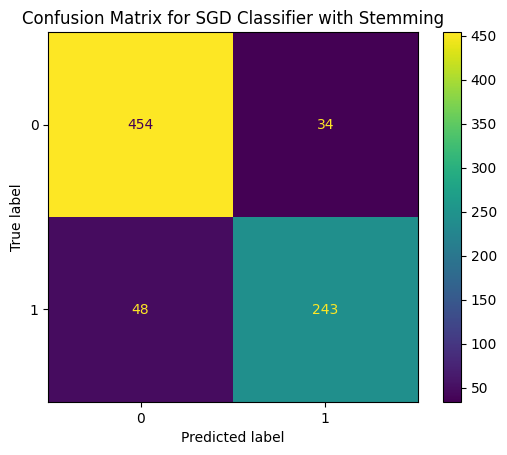

In [14]:
# confusion matrix
ConfusionMatrixDisplay.from_estimator(sgd_stem, X_test_stem, y_test)
plt.title('Confusion Matrix for SGD Classifier with Stemming')

#### Lemmatizing

In [15]:
# make a copy of the data
df_lemm = df.copy()

# lemmatize
from src.stemming_and_lemming import get_wordnet_pos, lemmatize_reviews

df_lemm['lemmatized'] = lemmatize_reviews(df['cleaned'])
df_lemm.head()

,recommended,cleaned,lemmatized
0,1,Very good flight following an equally good fli...,Very good flight follow an equally good flight...
1,1,An hours delay due to late arrival of the inco...,An hour delay due to late arrival of the incom...
2,0,I booked through BA because Loganair dont have...,I book through BA because Loganair dont have r...
3,0,British airways lost bags in LHR then found th...,British airway lose bag in LHR then find them ...
4,0,The check in process and reward loyalty progra...,The check in process and reward loyalty progra...


In [16]:
# split lemmatized data
X_train_lem, X_test_lem, y_train, y_test, tfidf_lem = split_and_vect(df_lemm, 'lemmatized', 'recommended')

# sgd classifier
sgd_lem = SGDClassifier()

# fit
sgd_lem.fit(X_train_lem, y_train)

# predict
y_pred_lem = cross_val_predict(sgd_lem, X_train_lem, y_train, cv = 5)

# classification report
print(classification_report(y_train, y_pred_lem))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1952
           1       0.81      0.68      0.74      1163

    accuracy                           0.82      3115
   macro avg       0.82      0.79      0.80      3115
weighted avg       0.82      0.82      0.82      3115



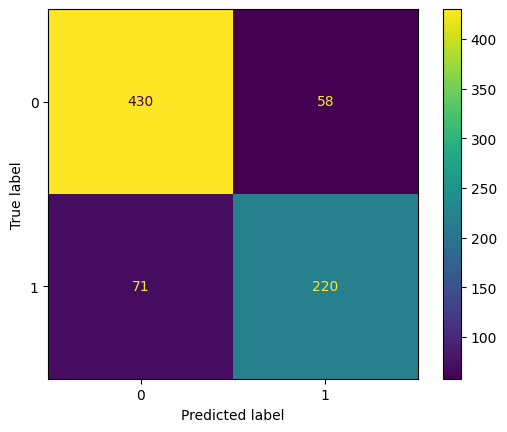

In [17]:
ConfusionMatrixDisplay.from_estimator(sgd_lem, X_test_lem, y_test)

### Hyperparameter Tuning with Optuna

In [18]:
import optuna
from sklearn.model_selection import cross_val_score

In [19]:
# create the optuna trial
def objective(trial: optuna.trial.Trial) -> float:
    '''Optuna Optimization Objective. Given the set of hyperparameters it will train a 
    model and return the average score based on cross-validation.'''
    # hyperparams
    hyperparams = {
        'loss': trial.suggest_categorical('loss', ['hinge', 'log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
        'alpha': trial.suggest_float('alpha', 1e-4, 1e-2),
        'max_iter': trial.suggest_int('max_iter', 1000, 5000),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1),
        'power_t': trial.suggest_float('power_t', 0.25, 0.75)
    }

    # create the model
    sgd_model = SGDClassifier(**hyperparams)

    # cross-val
    cross_val = cross_val_score(sgd_model, X_train_stem, y_train, cv = 3, scoring= 'accuracy')

    return cross_val.mean()


In [20]:
# run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-02-04 12:44:12,525] A new study created in memory with name: no-name-acceabf7-8140-44fd-bf9e-bff4146530d2
[I 2025-02-04 12:44:12,981] Trial 0 finished with value: 0.8035343504419483 and parameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.005337574999312715, 'max_iter': 1128, 'learning_rate': 'adaptive', 'eta0': 0.035622081198134314, 'power_t': 0.31258105359164967}. Best is trial 0 with value: 0.8035343504419483.
[I 2025-02-04 12:44:13,141] Trial 1 finished with value: 0.633707068515438 and parameters: {'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.0028931774614291994, 'max_iter': 2093, 'learning_rate': 'constant', 'eta0': 0.047846892776182814, 'power_t': 0.3752350588522805}. Best is trial 0 with value: 0.8035343504419483.
[I 2025-02-04 12:44:13,221] Trial 2 finished with value: 0.7627603736857299 and parameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0022661637857624064, 'max_iter': 4203, 'learning_rate': 'constant', 'eta0': 0.06796267373784

In [21]:
# best params
best_params = study.best_params
print(f'{best_params=}')

best_params={'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.00012247338883116036, 'max_iter': 3861, 'learning_rate': 'adaptive', 'eta0': 0.060134118477580156, 'power_t': 0.5404081282288249}


In [22]:
# fit model with new hyperparams
model_2 = SGDClassifier(**best_params)

model_2.fit(X_train_stem, y_train)

y_pred = model_2.predict(X_test_stem)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       488
           1       0.88      0.82      0.85       291

    accuracy                           0.89       779
   macro avg       0.89      0.88      0.88       779
weighted avg       0.89      0.89      0.89       779



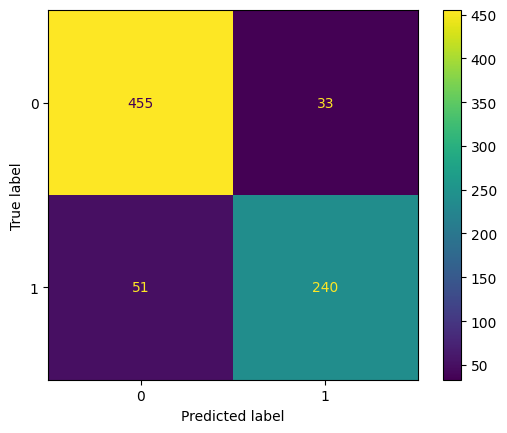

In [23]:
ConfusionMatrixDisplay.from_estimator(model_2, X_test_stem, y_test)

#### Adding Feature Selection Using Chi2

In [24]:
import optuna
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Objective function for Optuna
def objective(trial):
    # Suggest a value for the percentile
    percentile = trial.suggest_int('percentile', 10, 75)
    
    # Define hyperparameters in a dictionary
    hyperparams = {
        'loss': trial.suggest_categorical('loss', ['hinge', 'log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
        'alpha': trial.suggest_float('alpha', 1e-4, 1e-2),
        'max_iter': trial.suggest_int('max_iter', 1000, 5000),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1),
        'power_t': trial.suggest_float('power_t', 0.25, 0.75)
    }
    
    # Combine the percentile with hyperparameters
    best_params = {'percentile': percentile, **hyperparams}
    
    # Create the pipeline
    pipeline = get_pipeline(**best_params)
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X_train_stem, y_train, cv=3, scoring='accuracy')
    
    # Return the average accuracy
    return scores.mean()

# Create the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Output the best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

# Create the pipeline with the best hyperparameters
pipeline = get_pipeline(**best_params)

# Fit the pipeline to the training data
pipeline.fit(X_train_stem, y_train)

# Make predictions and evaluate the model (optional)
predictions = pipeline.predict(X_test_stem)
print(classification_report(y_test, predictions))


[I 2025-02-04 12:44:23,545] A new study created in memory with name: no-name-df5f067c-6468-4dc3-b736-d8d7e47e2974


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0006620834094955958, 'max_iter': 2518, 'learning_rate': 'adaptive', 'eta0': 0.015097710154563487, 'power_t': 0.5906685177311066}
Selecting best 68 percent of features.
Pipeline created.


[I 2025-02-04 12:44:24,836] Trial 0 finished with value: 0.8898936962632046 and parameters: {'percentile': 68, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0006620834094955958, 'max_iter': 2518, 'learning_rate': 'adaptive', 'eta0': 0.015097710154563487, 'power_t': 0.5906685177311066}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.005980402016773677, 'max_iter': 1373, 'learning_rate': 'adaptive', 'eta0': 0.04354980171196188, 'power_t': 0.4310247236139149}
Selecting best 32 percent of features.
Pipeline created.


[I 2025-02-04 12:44:25,989] Trial 1 finished with value: 0.6269664213218209 and parameters: {'percentile': 32, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.005980402016773677, 'max_iter': 1373, 'learning_rate': 'adaptive', 'eta0': 0.04354980171196188, 'power_t': 0.4310247236139149}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.007402303512961571, 'max_iter': 3378, 'learning_rate': 'constant', 'eta0': 0.03914240485446061, 'power_t': 0.6975575740291565}
Selecting best 34 percent of features.
Pipeline created.


[I 2025-02-04 12:44:27,099] Trial 2 finished with value: 0.6266452909428871 and parameters: {'percentile': 34, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.007402303512961571, 'max_iter': 3378, 'learning_rate': 'constant', 'eta0': 0.03914240485446061, 'power_t': 0.6975575740291565}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.005434009593740064, 'max_iter': 4946, 'learning_rate': 'optimal', 'eta0': 0.07484583467637168, 'power_t': 0.4004365175528485}
Selecting best 54 percent of features.
Pipeline created.


[I 2025-02-04 12:44:28,448] Trial 3 finished with value: 0.6269664213218209 and parameters: {'percentile': 54, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.005434009593740064, 'max_iter': 4946, 'learning_rate': 'optimal', 'eta0': 0.07484583467637168, 'power_t': 0.4004365175528485}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.008583905667429892, 'max_iter': 3377, 'learning_rate': 'invscaling', 'eta0': 0.06837242858190505, 'power_t': 0.5326550283817878}
Selecting best 13 percent of features.
Pipeline created.


[I 2025-02-04 12:44:29,627] Trial 4 finished with value: 0.6276083730032892 and parameters: {'percentile': 13, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.008583905667429892, 'max_iter': 3377, 'learning_rate': 'invscaling', 'eta0': 0.06837242858190505, 'power_t': 0.5326550283817878}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.008324239384954229, 'max_iter': 2385, 'learning_rate': 'optimal', 'eta0': 0.01838405991416414, 'power_t': 0.6591178416597648}
Selecting best 45 percent of features.
Pipeline created.


[I 2025-02-04 12:44:30,759] Trial 5 finished with value: 0.6266452909428871 and parameters: {'percentile': 45, 'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.008324239384954229, 'max_iter': 2385, 'learning_rate': 'optimal', 'eta0': 0.01838405991416414, 'power_t': 0.6591178416597648}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.0036663340387417635, 'max_iter': 3916, 'learning_rate': 'invscaling', 'eta0': 0.09650087214338955, 'power_t': 0.2647315369627006}
Selecting best 70 percent of features.
Pipeline created.


[I 2025-02-04 12:44:32,045] Trial 6 finished with value: 0.6266452909428871 and parameters: {'percentile': 70, 'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.0036663340387417635, 'max_iter': 3916, 'learning_rate': 'invscaling', 'eta0': 0.09650087214338955, 'power_t': 0.2647315369627006}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.004110091059048701, 'max_iter': 1595, 'learning_rate': 'invscaling', 'eta0': 0.05659830771257783, 'power_t': 0.40253697238387315}
Selecting best 54 percent of features.
Pipeline created.


[I 2025-02-04 12:44:33,169] Trial 7 finished with value: 0.6276083730032892 and parameters: {'percentile': 54, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.004110091059048701, 'max_iter': 1595, 'learning_rate': 'invscaling', 'eta0': 0.05659830771257783, 'power_t': 0.40253697238387315}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.006200278764195734, 'max_iter': 4521, 'learning_rate': 'adaptive', 'eta0': 0.055344620459880395, 'power_t': 0.3913606090808446}
Selecting best 70 percent of features.
Pipeline created.


[I 2025-02-04 12:44:34,547] Trial 8 finished with value: 0.6340312896583655 and parameters: {'percentile': 70, 'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.006200278764195734, 'max_iter': 4521, 'learning_rate': 'adaptive', 'eta0': 0.055344620459880395, 'power_t': 0.3913606090808446}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.0022390141246184615, 'max_iter': 4311, 'learning_rate': 'invscaling', 'eta0': 0.07206927470055462, 'power_t': 0.5880709795462093}
Selecting best 35 percent of features.
Pipeline created.


[I 2025-02-04 12:44:35,678] Trial 9 finished with value: 0.6266452909428871 and parameters: {'percentile': 35, 'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.0022390141246184615, 'max_iter': 4311, 'learning_rate': 'invscaling', 'eta0': 0.07206927470055462, 'power_t': 0.5880709795462093}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.000636353852494274, 'max_iter': 2318, 'learning_rate': 'adaptive', 'eta0': 0.0036035999946486923, 'power_t': 0.7453246955413919}
Selecting best 75 percent of features.
Pipeline created.


[I 2025-02-04 12:44:37,979] Trial 10 finished with value: 0.880582769732519 and parameters: {'percentile': 75, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.000636353852494274, 'max_iter': 2318, 'learning_rate': 'adaptive', 'eta0': 0.0036035999946486923, 'power_t': 0.7453246955413919}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0002639180816884981, 'max_iter': 2195, 'learning_rate': 'adaptive', 'eta0': 0.0028570008358030727, 'power_t': 0.7380423820104508}
Selecting best 75 percent of features.
Pipeline created.


[I 2025-02-04 12:44:40,323] Trial 11 finished with value: 0.8841145857479927 and parameters: {'percentile': 75, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0002639180816884981, 'max_iter': 2195, 'learning_rate': 'adaptive', 'eta0': 0.0028570008358030727, 'power_t': 0.7380423820104508}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00030575683656746647, 'max_iter': 2288, 'learning_rate': 'adaptive', 'eta0': 0.005616691033437392, 'power_t': 0.6240950556891498}
Selecting best 59 percent of features.
Pipeline created.


[I 2025-02-04 12:44:42,277] Trial 12 finished with value: 0.8892508173525382 and parameters: {'percentile': 59, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00030575683656746647, 'max_iter': 2288, 'learning_rate': 'adaptive', 'eta0': 0.005616691033437392, 'power_t': 0.6240950556891498}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.002054209853530367, 'max_iter': 2851, 'learning_rate': 'adaptive', 'eta0': 0.026843305447857086, 'power_t': 0.598387902103459}
Selecting best 61 percent of features.
Pipeline created.


[I 2025-02-04 12:44:43,872] Trial 13 finished with value: 0.86581664475315 and parameters: {'percentile': 61, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.002054209853530367, 'max_iter': 2851, 'learning_rate': 'adaptive', 'eta0': 0.026843305447857086, 'power_t': 0.598387902103459}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0020321730280673813, 'max_iter': 1840, 'learning_rate': 'constant', 'eta0': 0.01871582749735737, 'power_t': 0.618185766211073}
Selecting best 61 percent of features.
Pipeline created.


[I 2025-02-04 12:44:45,185] Trial 14 finished with value: 0.8664585964346182 and parameters: {'percentile': 61, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0020321730280673813, 'max_iter': 1840, 'learning_rate': 'constant', 'eta0': 0.01871582749735737, 'power_t': 0.618185766211073}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0011390610817519494, 'max_iter': 2911, 'learning_rate': 'adaptive', 'eta0': 0.02978782215049243, 'power_t': 0.5283862638424157}
Selecting best 61 percent of features.
Pipeline created.


[I 2025-02-04 12:44:46,398] Trial 15 finished with value: 0.8802644210411795 and parameters: {'percentile': 61, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0011390610817519494, 'max_iter': 2911, 'learning_rate': 'adaptive', 'eta0': 0.02978782215049243, 'power_t': 0.5283862638424157}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0037936517500791723, 'max_iter': 1143, 'learning_rate': 'adaptive', 'eta0': 0.013272743808202652, 'power_t': 0.4898761490609512}
Selecting best 47 percent of features.
Pipeline created.


[I 2025-02-04 12:44:47,832] Trial 16 finished with value: 0.8324280485596113 and parameters: {'percentile': 47, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0037936517500791723, 'max_iter': 1143, 'learning_rate': 'adaptive', 'eta0': 0.013272743808202652, 'power_t': 0.4898761490609512}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0029375941273642207, 'max_iter': 2586, 'learning_rate': 'adaptive', 'eta0': 0.011258946751063658, 'power_t': 0.6663446017350028}
Selecting best 55 percent of features.
Pipeline created.


[I 2025-02-04 12:44:49,074] Trial 17 finished with value: 0.8587542490278003 and parameters: {'percentile': 55, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0029375941273642207, 'max_iter': 2586, 'learning_rate': 'adaptive', 'eta0': 0.011258946751063658, 'power_t': 0.6663446017350028}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.001025354720000187, 'max_iter': 1936, 'learning_rate': 'constant', 'eta0': 0.027657764921566366, 'power_t': 0.5645923486665401}
Selecting best 18 percent of features.
Pipeline created.


[I 2025-02-04 12:44:50,349] Trial 18 finished with value: 0.8825092429297229 and parameters: {'percentile': 18, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.001025354720000187, 'max_iter': 1936, 'learning_rate': 'constant', 'eta0': 0.027657764921566366, 'power_t': 0.5645923486665401}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.009604873046913704, 'max_iter': 3510, 'learning_rate': 'optimal', 'eta0': 0.03489529295451235, 'power_t': 0.4818860953365409}
Selecting best 68 percent of features.
Pipeline created.


[I 2025-02-04 12:44:51,533] Trial 19 finished with value: 0.6837848630451567 and parameters: {'percentile': 68, 'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.009604873046913704, 'max_iter': 3510, 'learning_rate': 'optimal', 'eta0': 0.03489529295451235, 'power_t': 0.4818860953365409}. Best is trial 0 with value: 0.8898936962632046.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0001181873771897618, 'max_iter': 1939, 'learning_rate': 'adaptive', 'eta0': 0.004282940265458327, 'power_t': 0.6429377101323501}
Selecting best 40 percent of features.
Pipeline created.


[I 2025-02-04 12:44:53,289] Trial 20 finished with value: 0.8911772905497418 and parameters: {'percentile': 40, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0001181873771897618, 'max_iter': 1939, 'learning_rate': 'adaptive', 'eta0': 0.004282940265458327, 'power_t': 0.6429377101323501}. Best is trial 20 with value: 0.8911772905497418.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00017674361497093356, 'max_iter': 1974, 'learning_rate': 'adaptive', 'eta0': 0.002246532429828333, 'power_t': 0.6542575754893359}
Selecting best 40 percent of features.
Pipeline created.


[I 2025-02-04 12:44:55,150] Trial 21 finished with value: 0.882511097388119 and parameters: {'percentile': 40, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00017674361497093356, 'max_iter': 1974, 'learning_rate': 'adaptive', 'eta0': 0.002246532429828333, 'power_t': 0.6542575754893359}. Best is trial 20 with value: 0.8911772905497418.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.001677230550213316, 'max_iter': 2668, 'learning_rate': 'adaptive', 'eta0': 0.01183833173855313, 'power_t': 0.6417499621234504}
Selecting best 28 percent of features.
Pipeline created.


[I 2025-02-04 12:44:56,620] Trial 22 finished with value: 0.869669282071158 and parameters: {'percentile': 28, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.001677230550213316, 'max_iter': 2668, 'learning_rate': 'adaptive', 'eta0': 0.01183833173855313, 'power_t': 0.6417499621234504}. Best is trial 20 with value: 0.8911772905497418.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0012446925450775317, 'max_iter': 1677, 'learning_rate': 'adaptive', 'eta0': 0.02118228685321726, 'power_t': 0.7037871459471507}
Selecting best 50 percent of features.
Pipeline created.


[I 2025-02-04 12:44:58,166] Trial 23 finished with value: 0.878336402461979 and parameters: {'percentile': 50, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0012446925450775317, 'max_iter': 1677, 'learning_rate': 'adaptive', 'eta0': 0.02118228685321726, 'power_t': 0.7037871459471507}. Best is trial 20 with value: 0.8911772905497418.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00027238631833596285, 'max_iter': 2160, 'learning_rate': 'adaptive', 'eta0': 0.009127321151260843, 'power_t': 0.5619157319268857}
Selecting best 40 percent of features.
Pipeline created.


[I 2025-02-04 12:44:59,765] Trial 24 finished with value: 0.8898924599576071 and parameters: {'percentile': 40, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00027238631833596285, 'max_iter': 2160, 'learning_rate': 'adaptive', 'eta0': 0.009127321151260843, 'power_t': 0.5619157319268857}. Best is trial 20 with value: 0.8911772905497418.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.0028658366200179997, 'max_iter': 3112, 'learning_rate': 'adaptive', 'eta0': 0.011772046183353053, 'power_t': 0.5547118040182022}
Selecting best 39 percent of features.
Pipeline created.


[I 2025-02-04 12:45:01,041] Trial 25 finished with value: 0.6706246990368561 and parameters: {'percentile': 39, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.0028658366200179997, 'max_iter': 3112, 'learning_rate': 'adaptive', 'eta0': 0.011772046183353053, 'power_t': 0.5547118040182022}. Best is trial 20 with value: 0.8911772905497418.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.002665154161477874, 'max_iter': 1164, 'learning_rate': 'adaptive', 'eta0': 0.021513510440899747, 'power_t': 0.5775606832594546}
Selecting best 25 percent of features.
Pipeline created.


[I 2025-02-04 12:45:02,433] Trial 26 finished with value: 0.8552239783943234 and parameters: {'percentile': 25, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.002665154161477874, 'max_iter': 1164, 'learning_rate': 'adaptive', 'eta0': 0.021513510440899747, 'power_t': 0.5775606832594546}. Best is trial 20 with value: 0.8911772905497418.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0013978277627067332, 'max_iter': 1522, 'learning_rate': 'constant', 'eta0': 0.04322439817267798, 'power_t': 0.45801663222828853}
Selecting best 24 percent of features.
Pipeline created.


[I 2025-02-04 12:45:03,684] Trial 27 finished with value: 0.876730132414511 and parameters: {'percentile': 24, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0013978277627067332, 'max_iter': 1522, 'learning_rate': 'constant', 'eta0': 0.04322439817267798, 'power_t': 0.45801663222828853}. Best is trial 20 with value: 0.8911772905497418.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.004443520845528138, 'max_iter': 2040, 'learning_rate': 'optimal', 'eta0': 0.008164503608988936, 'power_t': 0.324683359988176}
Selecting best 42 percent of features.
Pipeline created.


[I 2025-02-04 12:45:04,868] Trial 28 finished with value: 0.7826639665752418 and parameters: {'percentile': 42, 'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.004443520845528138, 'max_iter': 2040, 'learning_rate': 'optimal', 'eta0': 0.008164503608988936, 'power_t': 0.324683359988176}. Best is trial 20 with value: 0.8911772905497418.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.006407171791747013, 'max_iter': 2583, 'learning_rate': 'adaptive', 'eta0': 0.04721316736300079, 'power_t': 0.5180867650721607}
Selecting best 29 percent of features.
Pipeline created.


[I 2025-02-04 12:45:06,044] Trial 29 finished with value: 0.6266452909428871 and parameters: {'percentile': 29, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.006407171791747013, 'max_iter': 2583, 'learning_rate': 'adaptive', 'eta0': 0.04721316736300079, 'power_t': 0.5180867650721607}. Best is trial 20 with value: 0.8911772905497418.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0007860826143566323, 'max_iter': 1007, 'learning_rate': 'adaptive', 'eta0': 0.03254655584864636, 'power_t': 0.6031862039592601}
Selecting best 36 percent of features.
Pipeline created.


[I 2025-02-04 12:45:07,228] Trial 30 finished with value: 0.8818688366302513 and parameters: {'percentile': 36, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0007860826143566323, 'max_iter': 1007, 'learning_rate': 'adaptive', 'eta0': 0.03254655584864636, 'power_t': 0.6031862039592601}. Best is trial 20 with value: 0.8911772905497418.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00025206031707871595, 'max_iter': 2265, 'learning_rate': 'adaptive', 'eta0': 0.006681249450009738, 'power_t': 0.6291041625182728}
Selecting best 49 percent of features.
Pipeline created.


[I 2025-02-04 12:45:08,965] Trial 31 finished with value: 0.8908558510944086 and parameters: {'percentile': 49, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00025206031707871595, 'max_iter': 2265, 'learning_rate': 'adaptive', 'eta0': 0.006681249450009738, 'power_t': 0.6291041625182728}. Best is trial 20 with value: 0.8911772905497418.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0001328118037494667, 'max_iter': 1379, 'learning_rate': 'adaptive', 'eta0': 0.015077176299327248, 'power_t': 0.7006621084486532}
Selecting best 50 percent of features.
Pipeline created.


[I 2025-02-04 12:45:10,549] Trial 32 finished with value: 0.8918189331548109 and parameters: {'percentile': 50, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0001328118037494667, 'max_iter': 1379, 'learning_rate': 'adaptive', 'eta0': 0.015077176299327248, 'power_t': 0.7006621084486532}. Best is trial 32 with value: 0.8918189331548109.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0014902344270578032, 'max_iter': 1319, 'learning_rate': 'adaptive', 'eta0': 0.01647075049626927, 'power_t': 0.6939075689463209}
Selecting best 50 percent of features.
Pipeline created.


[I 2025-02-04 12:45:12,099] Trial 33 finished with value: 0.8738433588444993 and parameters: {'percentile': 50, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0014902344270578032, 'max_iter': 1319, 'learning_rate': 'adaptive', 'eta0': 0.01647075049626927, 'power_t': 0.6939075689463209}. Best is trial 32 with value: 0.8918189331548109.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.0008166943644813225, 'max_iter': 1434, 'learning_rate': 'adaptive', 'eta0': 0.025211207921395796, 'power_t': 0.6960039471290045}
Selecting best 46 percent of features.
Pipeline created.


[I 2025-02-04 12:45:13,694] Trial 34 finished with value: 0.7929404477775243 and parameters: {'percentile': 46, 'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.0008166943644813225, 'max_iter': 1434, 'learning_rate': 'adaptive', 'eta0': 0.025211207921395796, 'power_t': 0.6960039471290045}. Best is trial 32 with value: 0.8918189331548109.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.005066539441103232, 'max_iter': 1813, 'learning_rate': 'constant', 'eta0': 0.0013406323371558159, 'power_t': 0.6802814296245551}
Selecting best 57 percent of features.
Pipeline created.


[I 2025-02-04 12:45:15,002] Trial 35 finished with value: 0.831786096878143 and parameters: {'percentile': 57, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.005066539441103232, 'max_iter': 1813, 'learning_rate': 'constant', 'eta0': 0.0013406323371558159, 'power_t': 0.6802814296245551}. Best is trial 32 with value: 0.8918189331548109.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.0032501216752024048, 'max_iter': 3133, 'learning_rate': 'optimal', 'eta0': 0.09601965539100303, 'power_t': 0.7179184017450749}
Selecting best 67 percent of features.
Pipeline created.


[I 2025-02-04 12:45:16,188] Trial 36 finished with value: 0.6288925854426252 and parameters: {'percentile': 67, 'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.0032501216752024048, 'max_iter': 3133, 'learning_rate': 'optimal', 'eta0': 0.09601965539100303, 'power_t': 0.7179184017450749}. Best is trial 32 with value: 0.8918189331548109.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.00012245885824090164, 'max_iter': 2455, 'learning_rate': 'invscaling', 'eta0': 0.03827725830274707, 'power_t': 0.639191360546578}
Selecting best 52 percent of features.
Pipeline created.


[I 2025-02-04 12:45:17,385] Trial 37 finished with value: 0.627929503382223 and parameters: {'percentile': 52, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.00012245885824090164, 'max_iter': 2455, 'learning_rate': 'invscaling', 'eta0': 0.03827725830274707, 'power_t': 0.639191360546578}. Best is trial 32 with value: 0.8918189331548109.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.0016963404710553162, 'max_iter': 1783, 'learning_rate': 'adaptive', 'eta0': 0.017949574985737078, 'power_t': 0.6713447458644346}
Selecting best 44 percent of features.
Pipeline created.


[I 2025-02-04 12:45:18,859] Trial 38 finished with value: 0.686034939232489 and parameters: {'percentile': 44, 'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.0016963404710553162, 'max_iter': 1783, 'learning_rate': 'adaptive', 'eta0': 0.017949574985737078, 'power_t': 0.6713447458644346}. Best is trial 32 with value: 0.8918189331548109.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.002396622128680681, 'max_iter': 3491, 'learning_rate': 'invscaling', 'eta0': 0.023731923601160495, 'power_t': 0.724624863162383}
Selecting best 65 percent of features.
Pipeline created.


[I 2025-02-04 12:45:20,007] Trial 39 finished with value: 0.6266452909428871 and parameters: {'percentile': 65, 'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.002396622128680681, 'max_iter': 3491, 'learning_rate': 'invscaling', 'eta0': 0.023731923601160495, 'power_t': 0.724624863162383}. Best is trial 32 with value: 0.8918189331548109.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0007763038670600612, 'max_iter': 2734, 'learning_rate': 'adaptive', 'eta0': 0.0634630623876681, 'power_t': 0.621089478702139}
Selecting best 32 percent of features.
Pipeline created.


[I 2025-02-04 12:45:21,205] Trial 40 finished with value: 0.8789802086018433 and parameters: {'percentile': 32, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0007763038670600612, 'max_iter': 2734, 'learning_rate': 'adaptive', 'eta0': 0.0634630623876681, 'power_t': 0.621089478702139}. Best is trial 32 with value: 0.8918189331548109.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0004872458726231007, 'max_iter': 2134, 'learning_rate': 'adaptive', 'eta0': 0.007903482958561086, 'power_t': 0.5640185847801703}
Selecting best 38 percent of features.
Pipeline created.


[I 2025-02-04 12:45:22,919] Trial 41 finished with value: 0.8882880443685353 and parameters: {'percentile': 38, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0004872458726231007, 'max_iter': 2134, 'learning_rate': 'adaptive', 'eta0': 0.007903482958561086, 'power_t': 0.5640185847801703}. Best is trial 32 with value: 0.8918189331548109.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0001123691128545097, 'max_iter': 2442, 'learning_rate': 'adaptive', 'eta0': 0.015162677591057126, 'power_t': 0.533425993914584}
Selecting best 47 percent of features.
Pipeline created.


[I 2025-02-04 12:45:24,478] Trial 42 finished with value: 0.8924611939126784 and parameters: {'percentile': 47, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0001123691128545097, 'max_iter': 2442, 'learning_rate': 'adaptive', 'eta0': 0.015162677591057126, 'power_t': 0.533425993914584}. Best is trial 42 with value: 0.8924611939126784.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.006949757490865008, 'max_iter': 2353, 'learning_rate': 'adaptive', 'eta0': 0.014250135040580512, 'power_t': 0.5443938150135839}
Selecting best 48 percent of features.
Pipeline created.


[I 2025-02-04 12:45:25,863] Trial 43 finished with value: 0.7662937350832002 and parameters: {'percentile': 48, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.006949757490865008, 'max_iter': 2353, 'learning_rate': 'adaptive', 'eta0': 0.014250135040580512, 'power_t': 0.5443938150135839}. Best is trial 42 with value: 0.8924611939126784.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0007436907776187177, 'max_iter': 1660, 'learning_rate': 'adaptive', 'eta0': 0.08432756261599716, 'power_t': 0.5929054348369889}
Selecting best 43 percent of features.
Pipeline created.


[I 2025-02-04 12:45:27,387] Trial 44 finished with value: 0.8879659867604035 and parameters: {'percentile': 43, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0007436907776187177, 'max_iter': 1660, 'learning_rate': 'adaptive', 'eta0': 0.08432756261599716, 'power_t': 0.5929054348369889}. Best is trial 42 with value: 0.8924611939126784.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.0018454712598103907, 'max_iter': 1348, 'learning_rate': 'adaptive', 'eta0': 0.01614075066673616, 'power_t': 0.6392858802781215}
Selecting best 53 percent of features.
Pipeline created.


[I 2025-02-04 12:45:28,983] Trial 45 finished with value: 0.7277676709795187 and parameters: {'percentile': 53, 'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.0018454712598103907, 'max_iter': 1348, 'learning_rate': 'adaptive', 'eta0': 0.01614075066673616, 'power_t': 0.6392858802781215}. Best is trial 42 with value: 0.8924611939126784.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00011216651267744273, 'max_iter': 2407, 'learning_rate': 'optimal', 'eta0': 0.005313379628316704, 'power_t': 0.4607922638654918}
Selecting best 50 percent of features.
Pipeline created.


[I 2025-02-04 12:45:30,196] Trial 46 finished with value: 0.8914959483174808 and parameters: {'percentile': 50, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00011216651267744273, 'max_iter': 2407, 'learning_rate': 'optimal', 'eta0': 0.005313379628316704, 'power_t': 0.4607922638654918}. Best is trial 42 with value: 0.8924611939126784.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0012171640839551514, 'max_iter': 2460, 'learning_rate': 'optimal', 'eta0': 0.007046632089543866, 'power_t': 0.4405695425013673}
Selecting best 50 percent of features.
Pipeline created.


[I 2025-02-04 12:45:31,356] Trial 47 finished with value: 0.8805840060381165 and parameters: {'percentile': 50, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0012171640839551514, 'max_iter': 2460, 'learning_rate': 'optimal', 'eta0': 0.007046632089543866, 'power_t': 0.4405695425013673}. Best is trial 42 with value: 0.8924611939126784.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0005339913385266669, 'max_iter': 2801, 'learning_rate': 'optimal', 'eta0': 0.005424642842023967, 'power_t': 0.3523794686231029}
Selecting best 58 percent of features.
Pipeline created.


[I 2025-02-04 12:45:32,509] Trial 48 finished with value: 0.8931012911357508 and parameters: {'percentile': 58, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0005339913385266669, 'max_iter': 2801, 'learning_rate': 'optimal', 'eta0': 0.005424642842023967, 'power_t': 0.3523794686231029}. Best is trial 48 with value: 0.8931012911357508.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.008256154447949953, 'max_iter': 3058, 'learning_rate': 'optimal', 'eta0': 0.0015630559522187863, 'power_t': 0.324634534726711}
Selecting best 56 percent of features.
Pipeline created.


[I 2025-02-04 12:45:33,655] Trial 49 finished with value: 0.736758085284069 and parameters: {'percentile': 56, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.008256154447949953, 'max_iter': 3058, 'learning_rate': 'optimal', 'eta0': 0.0015630559522187863, 'power_t': 0.324634534726711}. Best is trial 48 with value: 0.8931012911357508.


Best hyperparameters:  {'percentile': 58, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0005339913385266669, 'max_iter': 2801, 'learning_rate': 'optimal', 'eta0': 0.005424642842023967, 'power_t': 0.3523794686231029}
Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0005339913385266669, 'max_iter': 2801, 'learning_rate': 'optimal', 'eta0': 0.005424642842023967, 'power_t': 0.3523794686231029}
Selecting best 58 percent of features.
Pipeline created.
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       488
           1       0.87      0.81      0.84       291

    accuracy                           0.88       779
   macro avg       0.88      0.87      0.87       779
weighted avg       0.88      0.88      0.88       779



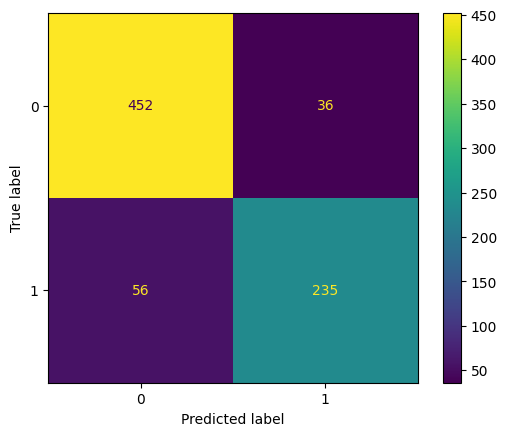

In [25]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test_stem, y_test)

### The Precision/Recall Trade-off

Increasing percision will decrease recall and vice-versa.

#### The Decision Function

The **SGDClassifier** will make its predictions by computing a score based on a *decision function*. If a score is greater than the threshold it will be assigned to the positive class and if not it will be assigned to the negative class. The default threshold for our model is 0. If we increase the threshold our precision will go up and the recall will go down. As a reminder before we do so, here is the current f1 score for our model.

In [26]:

from sklearn.metrics import f1_score

f1 = f1_score(y_test, predictions)
print(f1)

0.8362989323843416


In [27]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       488
           1       0.87      0.81      0.84       291

    accuracy                           0.88       779
   macro avg       0.88      0.87      0.87       779
weighted avg       0.88      0.88      0.88       779



Sklearn does not have a way for us to set this threshold but we can do so manually. First, we need to access the decision function. This will give us the score for a specific instance that was used to make its prediction.  Below we have the first 10 decision scores. There are 3 scores greater than 0 which symbolize the positive class predictions. These scores are derived from the linear combination of variables that were optimized in our model pipeline.

In [28]:
# scores 
y_scores = pipeline.decision_function(X_test_stem)
first_ten = y_scores[:10]
print(first_ten)

[-0.47654355 -0.0797666  -1.94894592 -0.62640172 -0.98010055  0.39459634
  0.46272955  1.24597718 -0.29686651 -1.23624963]


In [45]:
# decision scores are by default based on a 0 threshold, 3 positive cases predicted
threshold = 0
y_some_review_pred = (first_ten > threshold)
print(y_some_review_pred)

[False False False False False  True  True  True False False]


Now they are all False, or in our case, classified as negative reviews. This will of course reduce recall since we will have fewer false positives. This makes the model more strict about classifying a sample as a positive review. This also reduces recall since we will have more false negatives. 

In [74]:
from sklearn.metrics import confusion_matrix

# Get the true and predicted labels
y_true = y_test
y_pred = pipeline.predict(X_test_stem)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Extract indices for False Positives and False Negatives
false_positives_indices = y_test[(y_true == 0) & (y_pred == 1)].index
false_negatives_indices = y_test[(y_true == 1) & (y_pred == 0)].index

# Get the corresponding rows from the original DataFrame
false_positives = df.loc[false_positives_indices, :]
false_negatives = df.loc[false_negatives_indices, :]

# Display False Positives and False Negatives
print("False Positives:")
print(false_positives[['cleaned', 'recommended']])
print("\nFalse Negatives:")
print(false_negatives[['cleaned', 'recommended']])


False Positives:
                                                cleaned  recommended
2249  Flew from Bangkok to London Heathrow Once agai...            0
3431  Washington   LHR We arrived early for our 1830...            0
699   Flew Club Europe London   Tenerife South 5 Nov...            0
1462  Fort Lauderdale to Gatwick An efficient courte...            0
1467  Gatwick to Madeira The flight left on time and...            0
1386  The overall flight wasnt too bad Seats and eve...            0
3631  Flew SYD SIN and had a reasonably comfortable ...            0
3407  We flew from Manchester to LHR to YCC and retu...            0
1670  Gatwick to Tirana Full flight on both outward ...            0
2927  Glasgow to Cape Town via Heathrow with British...            0
523   Flight was 1 hour late leaving gate Crew were ...            0
1539  Toronto to London return – business to London ...            0
3377  Regularly travel from BCN to LHR In addition t...            0
1504  A fairly av

In [75]:
print(false_positives.loc[463, 'cleaned'])

I must admit like many others I tend to avoid BA long haul where possible due to the many poor reviews But had my first ride on a BA A380 the other day so it was an exception What can I say Aircraft immaculate and economy seat really comfortable but thats about it IFE didnt work but wasnt that interesting anyway I got the map screenshot for a while Lunch was poor quality but plenty of nice white wine and other alcoholic drinks made up for it Cabin crew pleasant but poor grooming lets them down Some skirts some trouser suits some long sleeves some short Some jackets some waistcoat Some cardigans on at time and all in all they could have done better I think Baggage delivery was really quick Summing up well I am still not coming back to BA not yet Maybe the old charm will return soon


As we can see, the length of our false_positives matches those in our confusion matrix. These are the instances where the decision_function results in a value greater than our threshold 0.

In [76]:
len(false_positives)

36

If we increase this threshold, our precision will go up and our recall will go down and vice versa. This is because decision function values that are higher will be more accurate predictions. (generally)